chainerの場合、データは列ベクトルにしないといけない(sklearnと同様)。(144,) --> (144,1)

時系列のデータが増えると記憶に蓄積されながら学習を進めていく。<br>
時系列の**初期より中後半**の方が予測がうまくいくようになっている。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# csvファイルを読み込み、データフレーム形式で表示
df = pd.read_csv('./international-airline-passengers.csv')  # クオーテーションの中は、csvファイルが置いてある場所を各自指定してください

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.tail()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [5]:
df.columns = ['month','passengers']
df = df.iloc[:-1]

In [6]:
df.tail()

,month,passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


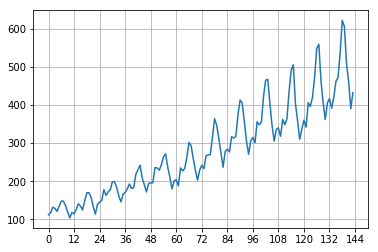

In [7]:
# データの可視化
plt.plot(df['passengers'])
plt.xticks(np.arange(0, 145, 12)) # 12ヶ月ごとにグリッド線を表示
plt.grid()
plt.show()

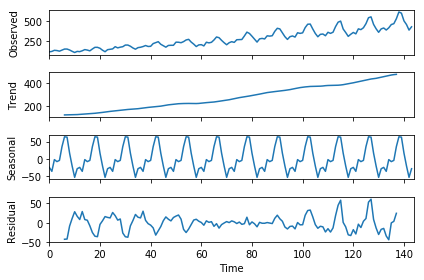

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(df.passengers.values,freq=12)
sd.plot()
plt.show()

時系列データを
- 長期変動(trend)
- 周期変動(seasonal)
- ノイズ、残差(residual)

の３つの要素に分けて傾向を確認できる。

In [9]:
# データをchainerが扱える型に変換
data = df['passengers'].values
data = data.astype(np.float32)
scale = data.max()
data /= data.max()

In [10]:
data.shape

(144,)

In [12]:
data = data[:,np.newaxis]

In [13]:
data.shape

(144, 1)

In [14]:
# 最初と最後のサンプルをひとつずつ削る
# １番目は予測に使えない。最後のデータは学習に使えない。
X = data[:-1]
y = data[1:]

時系列性を失わないようにtestとtrainを分割しなければならない

In [15]:
# 訓練データのサンプル数を指定
train_size = int(len(data) * 0.7)
print(train_size)

100


In [16]:
# データの分割
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [17]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import training
from chainer.training import extensions
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import datasets, iterators, serializers, training, report, Variable

/Users/zukako/.pyenv/versions/anaconda3-4.0.0/envs/chainer2_py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
# ネットワークの定義
class MyLSTM(chainer.Chain):
    def __init__(self,n_inputs,n_units,n_outputs):
        super(MyLSTM, self).__init__()
        with self.init_scope():
            self.xh = L.Linear(n_inputs,n_units)
            self.hh = L.LSTM(n_units,n_units)
            self.yh = L.Linear(n_units,n_outputs)
            
    def __call__(self,x):
        h1 = self.xh(x)
        h2 = self.hh(h1)
        y = self.yh(h2)
        return y
    
    # 中間層の記憶を初期化する関数
    def reset_state(self):
        self.hh.reset_state()

In [21]:
# 誤差関数を新たに定義
# 誤差関数を定義する関数
class LossFunc(chainer.Chain):
    def __init__(self, predictor): #　インスタンス生成時にモデルも入力する
        super(LossFunc, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss}, self)
        return loss

In [26]:
# モデルのインスタンスをOptimizerに適用
model = LossFunc(MyLSTM(n_inputs=1,n_units=5,n_outputs=1)) 
optimizer = optimizers.Adam()
optimizer.setup(model)

# epoch数を定義
n_epoch = 1000

In [27]:
# LSTM用のIterator
# 通常のiterator,updaterでは回らない
class LSTM_test_Iterator(chainer.dataset.Iterator):
    def __init__(self, dataset, batch_size = 10, seq_len = 5, repeat = True):
        self.seq_length = seq_len
        self.dataset = dataset
        self.nsamples =  len(dataset)
        self.batch_size = batch_size
        self.repeat = repeat
        self.epoch = 0
        self.iteration = 0
        self.offsets = np.random.randint(0, len(dataset),size=batch_size)
        self.is_new_epoch = False

    def __next__(self):
        if not self.repeat and self.iteration * self.batch_size >= self.nsamples:
            raise StopIteration
        x, t = self.get_data()
        self.iteration += 1
        epoch = self.iteration // self.batch_size
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch
            self.offsets = np.random.randint(0, self.nsamples,size=self.batch_size)
        return list(zip(x, t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / len(self.dataset)

    def get_data(self):
        tmp0 = [self.dataset[(offset + self.iteration)%self.nsamples][0]
               for offset in self.offsets]
        tmp1 = [self.dataset[(offset + self.iteration + 1)%self.nsamples][0]
               for offset in self.offsets]
        return tmp0,tmp1

    def serialzie(self, serialzier):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch     = serializer('epoch', self.epoch)

# LSTM用のUpdater
class LSTM_updater(training.StandardUpdater):
    def __init__(self, train_iter, optimizer, device):
        super(LSTM_updater, self).__init__(train_iter, optimizer, device=device)
        self.seq_length = train_iter.seq_length

    def update_core(self):
        loss = 0
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        for i in range(self.seq_length):
            batch = np.array(train_iter.__next__()).astype(np.float32)
            x, t  = batch[:,0].reshape((-1,1)), batch[:,1].reshape((-1,1))
            loss += optimizer.target(chainer.Variable(x), chainer.Variable(t))
        optimizer.target.zerograds()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()

In [28]:
train = tuple_dataset.TupleDataset(X_train,y_train)
test = tuple_dataset.TupleDataset(X_test,y_test)
# Iteratorを生成
# SerialIteratorではなく､LSTM_test_Iteratorを利用
# seq_lenはミニバッチの系列の長さを表す。
# 10個の入力をみてパラメータを更新？
train_iter = LSTM_test_Iterator(train,batch_size=10,seq_len=10)
test_iter = LSTM_test_Iterator(test,batch_size=10,seq_len=10)

# Updaterの生成
# StandardUpdaterではなく､LSTM_updaterを利用
updater = LSTM_updater(train_iter, optimizer, device=-1)
# trainerにupdaterを渡す
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out = 'result')

# Evaluatorの定義
eval_model = model.copy()
eval_rnn = eval_model.predictor
eval_rnn.train = False
trainer.extend(extensions.Evaluator(test_iter,eval_model,device=-1,
                          eval_hook=lambda _: eval_rnn.reset_state()))

# Adamの学習率を指定
trainer.extend(extensions.ExponentialShift("alpha", 1.00000001))
# 学習ログを出力
trainer.extend(extensions.LogReport())
# 学習ログを画像で出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='dl6_loss.png'))

In [29]:
# 学習の実行（推奨環境では10分程度で終了します）
trainer.run()

KeyboardInterrupt: 

In [ ]:
# PlotReportによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

In [ ]:
# 誤差をグラフ描画
show_graph('result/dl6_loss.png')